Libraries needed!

In [2]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import numpy as np
from scipy import sparse
import os
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from rdkit.Chem import rdFMCS
from collections import defaultdict

Diversity prediction of all ER inactives

In [3]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list - from notebook"""
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

# Read SMILES file
input_path = 'all_inactive.smi'
with open(input_path, 'r') as f:
    smiles_list = [line.strip().split()[0] for line in f if line.strip()]

# Generate fingerprints using MorganGenerator as in notebook
fpg = GetMorganGenerator(radius=2, fpSize=2048)
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
fps = [fpg.GetFingerprint(mol) for mol in mols if mol is not None]

# Calculate dissimilarity matrix
dissimilarity_matrix = tanimoto_distance_matrix(fps)

# Calculate diversity metrics
dissimilarities = np.array(dissimilarity_matrix)
print("\nTotal Dataset Diversity Analysis:")
print("-" * 40)
print(f"Number of molecules: {len(smiles_list)}")
print(f"Average dissimilarity: {np.mean(dissimilarities):.3f}")
print(f"Maximum dissimilarity: {np.max(dissimilarities):.3f}")
print(f"Minimum dissimilarity: {np.min(dissimilarities):.3f}")
print(f"Standard deviation: {np.std(dissimilarities):.3f}")

[13:33:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 16
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 26
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 16
[13:33:38] Can't kekulize mol.  Unkekulized atoms: 63 64


Total Dataset Diversity Analysis:
----------------------------------------
Number of molecules: 7153
Average dissimilarity: 0.919
Maximum dissimilarity: 1.000
Minimum dissimilarity: 0.000
Standard deviation: 0.058


BitBIRCH clustering on all ER inactives

In [4]:
def jt_isim(c_total, n_objects):
    sum_kq = np.sum(c_total)
    sum_kqsq = np.dot(c_total, c_total)
    a = (sum_kqsq - sum_kq)/2
    
    epsilon = 1e-10
    denominator = a + n_objects * sum_kq - sum_kqsq + epsilon
    return np.divide(a, denominator, where=denominator!=0)

def max_separation(X):
    n_samples = len(X)
    linear_sum = np.sum(X, axis=0)
    centroid = calc_centroid(linear_sum, n_samples)
    
    pop_counts = np.sum(X, axis=1)
    a_centroid = np.dot(X, centroid)
    
    epsilon = 1e-10
    denominator1 = pop_counts + np.sum(centroid) - a_centroid + epsilon
    sims_med = np.divide(a_centroid, denominator1, where=denominator1!=0)
    
    mol1 = np.argmin(sims_med)
    
    a_mol1 = np.dot(X, X[mol1])
    denominator2 = pop_counts + pop_counts[mol1] - a_mol1 + epsilon
    sims_mol1 = np.divide(a_mol1, denominator2, where=denominator2!=0)
    
    mol2 = np.argmin(sims_mol1)
    
    a_mol2 = np.dot(X, X[mol2])
    denominator3 = pop_counts + pop_counts[mol2] - a_mol2 + epsilon
    sims_mol2 = np.divide(a_mol2, denominator3, where=denominator3!=0)
    
    return (mol1, mol2), sims_mol1, sims_mol2

def calc_centroid(linear_sum, n_samples):
    """Calculate centroid based on linear sum and number of samples"""
    return np.where(linear_sum >= n_samples * 0.5, 1, 0)

def _iterate_sparse_X(X):
    """Iterator for sparse matrix X"""
    n_samples, n_features = X.shape
    X_indices = X.indices
    X_data = X.data
    X_indptr = X.indptr

    for i in range(n_samples):
        row = np.zeros(n_features)
        startptr, endptr = X_indptr[i], X_indptr[i + 1]
        nonzero_indices = X_indices[startptr:endptr]
        row[nonzero_indices] = X_data[startptr:endptr]
        yield row

def _split_node(node, threshold, branching_factor):
    """Split a node into two subclusters"""
    new_subcluster1 = _BFSubcluster()
    new_subcluster2 = _BFSubcluster()
    new_node1 = _BFNode(
        threshold=threshold,
        branching_factor=branching_factor,
        is_leaf=node.is_leaf,
        n_features=node.n_features,
        dtype=node.init_centroids_.dtype,
    )
    new_node2 = _BFNode(
        threshold=threshold,
        branching_factor=branching_factor,
        is_leaf=node.is_leaf,
        n_features=node.n_features,
        dtype=node.init_centroids_.dtype,
    )
    new_subcluster1.child_ = new_node1
    new_subcluster2.child_ = new_node2

    if node.is_leaf:
        if node.prev_leaf_ is not None:
            node.prev_leaf_.next_leaf_ = new_node1
        new_node1.prev_leaf_ = node.prev_leaf_
        new_node1.next_leaf_ = new_node2
        new_node2.prev_leaf_ = new_node1
        new_node2.next_leaf_ = node.next_leaf_
        if node.next_leaf_ is not None:
            node.next_leaf_.prev_leaf_ = new_node2

    farthest_idx, node1_dist, node2_dist = max_separation(node.centroids_)
    node1_closer = node1_dist > node2_dist
    node1_closer[farthest_idx[0]] = True

    for idx, subcluster in enumerate(node.subclusters_):
        if node1_closer[idx]:
            new_node1.append_subcluster(subcluster)
            new_subcluster1.update(subcluster)
        else:
            new_node2.append_subcluster(subcluster)
            new_subcluster2.update(subcluster)
    return new_subcluster1, new_subcluster2

class _BFNode:
    """Node class for BitBirch tree"""
    def __init__(self, *, threshold, branching_factor, is_leaf, n_features, dtype):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.is_leaf = is_leaf
        self.n_features = n_features
        self.subclusters_ = []
        self.init_centroids_ = np.zeros((branching_factor + 1, n_features), dtype=dtype)
        self.prev_leaf_ = None
        self.next_leaf_ = None
        self.centroids_ = None

    def append_subcluster(self, subcluster):
        """Append a new subcluster to the node"""
        n_samples = len(self.subclusters_)
        self.subclusters_.append(subcluster)
        self.init_centroids_[n_samples] = subcluster.centroid_
        self.centroids_ = self.init_centroids_[: n_samples + 1, :]

    def update_split_subclusters(self, subcluster, new_subcluster1, new_subcluster2):
        """Update subclusters after splitting"""
        ind = self.subclusters_.index(subcluster)
        self.subclusters_[ind] = new_subcluster1
        self.init_centroids_[ind] = new_subcluster1.centroid_
        self.centroids_[ind] = new_subcluster1.centroid_
        self.append_subcluster(new_subcluster2)

    def insert_bf_subcluster(self, subcluster, set_bits):
        """Insert a new subcluster using BIRCH strategy"""
        if not self.subclusters_:
            self.append_subcluster(subcluster)
            return False

        # Find closest subcluster
        a = np.dot(self.centroids_, subcluster.centroid_)
        epsilon = 1e-10
        denominator = np.sum(self.centroids_, axis=1) + set_bits - a + epsilon
        sim_matrix = np.divide(a, denominator, where=denominator!=0)
        closest_index = np.argmax(sim_matrix)
        closest_subcluster = self.subclusters_[closest_index]

        if closest_subcluster.child_ is not None:
            split_child = closest_subcluster.child_.insert_bf_subcluster(subcluster, set_bits)
            
            if not split_child:
                closest_subcluster.update(subcluster)
                self.init_centroids_[closest_index] = self.subclusters_[closest_index].centroid_
                self.centroids_[closest_index] = self.subclusters_[closest_index].centroid_
                return False

            else:
                new_subcluster1, new_subcluster2 = _split_node(
                    closest_subcluster.child_,
                    self.threshold,
                    self.branching_factor
                )
                self.update_split_subclusters(
                    closest_subcluster, new_subcluster1, new_subcluster2
                )

                return len(self.subclusters_) > self.branching_factor

        else:
            merged = closest_subcluster.merge_subcluster(subcluster, self.threshold)
            if merged:
                self.centroids_[closest_index] = closest_subcluster.centroid_
                self.init_centroids_[closest_index] = closest_subcluster.centroid_
                return False

            elif len(self.subclusters_) < self.branching_factor:
                self.append_subcluster(subcluster)
                return False

            else:
                self.append_subcluster(subcluster)
                return True

class _BFSubcluster:
    """Subcluster class for BitBirch"""
    def __init__(self, *, linear_sum=None, mol_indices=None):
        if linear_sum is None:
            self.n_samples_ = 0
            self.centroid_ = self.linear_sum_ = 0
            self.mol_indices = []
        else:
            self.n_samples_ = 1
            self.centroid_ = self.linear_sum_ = linear_sum
            self.mol_indices = mol_indices if mol_indices is not None else []
        self.child_ = None

    def update(self, subcluster):
        """Update subcluster with new data"""
        self.n_samples_ += subcluster.n_samples_
        self.linear_sum_ += subcluster.linear_sum_
        self.mol_indices += subcluster.mol_indices
        self.centroid_ = calc_centroid(self.linear_sum_, self.n_samples_)

    def merge_subcluster(self, nominee_cluster, threshold):
        """Attempt to merge with another subcluster"""
        new_ls = self.linear_sum_ + nominee_cluster.linear_sum_
        new_n = self.n_samples_ + nominee_cluster.n_samples_
        new_centroid = calc_centroid(new_ls, new_n)
        
        jt_sim = jt_isim(new_ls + new_centroid, new_n + 1) * (new_n + 1) - jt_isim(new_ls, new_n) * (new_n - 1)
        
        if jt_sim >= threshold * 2:
            self.n_samples_ = new_n
            self.linear_sum_ = new_ls
            self.centroid_ = new_centroid
            self.mol_indices = self.mol_indices + nominee_cluster.mol_indices
            return True
        return False

class BitBirch:
    """BitBirch clustering algorithm"""
    def __init__(self, *, threshold=0.5, branching_factor=50):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.index_tracker = 0
        self.first_call = True
        self.root_ = None
        self.dummy_leaf_ = None
        self.subcluster_centers_ = None
        self._n_features_out = None

    def fit(self, X):
        """Fit BitBirch clustering"""
        if not isinstance(X, (np.ndarray, sparse.spmatrix)):
            raise ValueError("Input X must be a numpy array or sparse matrix")
        
        if X.ndim != 2:
            raise ValueError("Input X must be 2-dimensional")
        
        if X.shape[0] == 0:
            raise ValueError("Input X must not be empty")
            
        return self._fit(X)

    def _fit(self, X):
        """Internal fit method"""
        if self.first_call:
            self.root_ = _BFNode(
                threshold=self.threshold,
                branching_factor=self.branching_factor,
                is_leaf=True,
                n_features=X.shape[1],
                dtype=X.dtype,
            )
            
            self.dummy_leaf_ = _BFNode(
                threshold=self.threshold,
                branching_factor=self.branching_factor,
                is_leaf=True,
                n_features=X.shape[1],
                dtype=X.dtype,
            )
            self.dummy_leaf_.next_leaf_ = self.root_
            self.root_.prev_leaf_ = self.dummy_leaf_

        iter_func = _iterate_sparse_X if sparse.issparse(X) else iter

        for sample in iter_func(X):
            set_bits = np.sum(sample)
            subcluster = _BFSubcluster(linear_sum=sample, mol_indices=[self.index_tracker])
            split = self.root_.insert_bf_subcluster(subcluster, set_bits)

            if split:
                new_subcluster1, new_subcluster2 = _split_node(
                    self.root_, self.threshold, self.branching_factor
                )
                del self.root_
                self.root_ = _BFNode(
                    threshold=self.threshold,
                    branching_factor=self.branching_factor,
                    is_leaf=False,
                    n_features=X.shape[1],
                    dtype=X.dtype,
                )
                self.root_.append_subcluster(new_subcluster1)
                self.root_.append_subcluster(new_subcluster2)
            self.index_tracker += 1

        centroids = np.concatenate([leaf.centroids_ for leaf in self._get_leaves()])
        self.subcluster_centers_ = centroids
        self._n_features_out = self.subcluster_centers_.shape[0]
        
        self.first_call = False
        return self

    def _get_leaves(self):
        """Get all leaf nodes"""
        leaf_ptr = self.dummy_leaf_.next_leaf_
        leaves = []
        while leaf_ptr is not None:
            leaves.append(leaf_ptr)
            leaf_ptr = leaf_ptr.next_leaf_
        return leaves
    
    def get_centroids(self):
        """Get cluster centroids"""
        if self.first_call:
            raise ValueError('The model has not been fitted yet.')
        
        centroids = []
        for leaf in self._get_leaves():
            for subcluster in leaf.subclusters_:
                centroids.append(subcluster.centroid_)
        return centroids
    
    def get_cluster_mol_ids(self):
        """Get molecule IDs for each cluster"""
        if self.first_call:
            raise ValueError('The model has not been fitted yet.')
        
        clusters_mol_id = []
        for leaf in self._get_leaves():
            for subcluster in leaf.subclusters_:
                clusters_mol_id.append(subcluster.mol_indices)
        return clusters_mol_id

File loading, number of clusters

In [4]:
def smiles_to_fingerprints(smiles_list, fp_type='rdkit', fp_length=2048):
    fingerprints = []
    for smiles in smiles_list:
        try:
            mol = Chem.MolFromSmiles(str(smiles).strip(), sanitize=False)
            if mol is not None:
                Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_ALL^Chem.SANITIZE_KEKULIZE)
                
                if fp_type == 'rdkit':
                    fp = AllChem.RDKFingerprint(mol, fpSize=fp_length)
                elif fp_type == 'morgan':
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=fp_length)
                else:
                    raise ValueError(f"Unsupported fingerprint type: {fp_type}")
                
                fingerprints.append(np.array(fp))
            else:
                print(f"Could not convert SMILES: {smiles}")
                fingerprints.append(np.zeros(fp_length))
                
        except Exception as e:
            print(f"Error processing SMILES {smiles}: {str(e)}")
            fingerprints.append(np.zeros(fp_length))
    
    return np.array(fingerprints)

def read_smi_file(file_path):
    with open(file_path, 'r') as f:
        smiles_list = [line.strip().split()[0] for line in f if line.strip()]
    return smiles_list

# Create output directory
output_path = '0.65t_0.5b_AI'
os.makedirs(output_path, exist_ok=True)

# Run clustering
input_path = 'all_inactive.smi'
smiles_list = read_smi_file(input_path)
X = smiles_to_fingerprints(smiles_list)

# Initialize and fit BitBIRCH
birch_clustering = BitBirch(threshold=0.65, branching_factor=50)
birch_clustering.fit(X)

# Get cluster information
cluster_mol_ids = birch_clustering.get_cluster_mol_ids()

# Write cluster files and create summary
cluster_summary = []
for idx, mol_indices in enumerate(cluster_mol_ids):
    cluster_smiles = [smiles_list[i] for i in mol_indices]
    
    # Write cluster to separate file
    cluster_file = os.path.join(output_path, f'cluster_{idx}.smi')
    with open(cluster_file, 'w') as f:
        for smiles in cluster_smiles:
            f.write(f"{smiles}\n")
    
    # Collect cluster summary
    cluster_summary.append({
        'cluster_id': idx,
        'size': len(mol_indices),
        'file': cluster_file
    })

# Write summary file
summary_file = os.path.join(output_path, 'cluster_summary.txt')
with open(summary_file, 'w') as f:
    f.write("Cluster ID | Size | Filename\n")
    f.write("-" * 40 + "\n")
    for cluster in cluster_summary:
        f.write(f"{cluster['cluster_id']:9} | {cluster['size']:4} | {cluster['file']}\n")

print(f"Total Clusters: {len(cluster_mol_ids)}")
print(f"Cluster summary saved to: {summary_file}")
print(f"Individual cluster files saved in: {output_path}")

[09:38:33] Explicit valence for atom # 0 Cl, 1, is greater than permitted


Error processing SMILES [Cl-][Pt]1([Cl-])NCCN1: Explicit valence for atom # 0 Cl, 1, is greater than permitted


[09:39:15] Explicit valence for atom # 2 Cl, 1, is greater than permitted


Error processing SMILES [NH4+].[NH4+].[Cl-][Pt+2]([Cl-])([Cl-])[Cl-]: Explicit valence for atom # 2 Cl, 1, is greater than permitted
Total Clusters: 3537
Cluster summary saved to: 0.65t_0.5b_AI\cluster_summary.txt
Individual cluster files saved in: 0.65t_0.5b_AI


Singletons based on Tanimoto similarity

In [5]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []

    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

def intra_tanimoto(fps_clusters):
    """Compute Tanimoto similarity for all pairs of fingerprints in each cluster."""
    intra_similarity = []
    for cluster in fps_clusters:
        if len(cluster) > 1:  
            intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
        else:
            intra_similarity.append([]) 
    return intra_similarity

# Your existing functions
def smiles_to_fingerprints(smiles_list, fp_type='rdkit', fp_length=2048):
    fingerprints = []
    rdkit_fps = []  # For RDKit fingerprint objects
    for smiles in smiles_list:
        try:
            mol = Chem.MolFromSmiles(str(smiles).strip(), sanitize=False)
            if mol is not None:
                Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_ALL^Chem.SANITIZE_KEKULIZE)
                
                if fp_type == 'rdkit':
                    fp = AllChem.RDKFingerprint(mol, fpSize=fp_length)
                elif fp_type == 'morgan':
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=fp_length)
                else:
                    raise ValueError(f"Unsupported fingerprint type: {fp_type}")
                
                fingerprints.append(np.array(fp))
                rdkit_fps.append(fp)  # Store RDKit fingerprint object
            else:
                print(f"Could not convert SMILES: {smiles}")
                fingerprints.append(np.zeros(fp_length))
                rdkit_fps.append(None)
                
        except Exception as e:
            print(f"Error processing SMILES {smiles}: {str(e)}")
            fingerprints.append(np.zeros(fp_length))
            rdkit_fps.append(None)
    
    return np.array(fingerprints), rdkit_fps

def read_smi_file(file_path):
    with open(file_path, 'r') as f:
        smiles_list = [line.strip().split()[0] for line in f if line.strip()]
    return smiles_list

# Create output directory
output_path = '0.65t_0.5b_AI'
os.makedirs(output_path, exist_ok=True)

# Run clustering
input_path = 'all_inactive.smi'
smiles_list = read_smi_file(input_path)
X, rdkit_fps = smiles_to_fingerprints(smiles_list)

# Initialize and fit BitBIRCH
birch_clustering = BitBirch(threshold=0.65, branching_factor=50)
birch_clustering.fit(X)

# Get cluster information
cluster_mol_ids = birch_clustering.get_cluster_mol_ids()

# Prepare fingerprints for diversity analysis
mol_fps_per_cluster = []
for cluster_indices in cluster_mol_ids:
    cluster_fps = [rdkit_fps[i] for i in cluster_indices if rdkit_fps[i] is not None]
    mol_fps_per_cluster.append(cluster_fps)

# Calculate intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

# Check for empty clusters (singletons)
empty = [i for i in range(len(intra_sim)) if not intra_sim[i]]
print(f"Number of singleton clusters: {len(empty)}")

# Filter out empty similarity arrays and keep corresponding cluster indices
valid_sim = [(i, sim) for i, sim in enumerate(intra_sim) if len(sim) > 0]

# Order clusters by size (most populated to least populated)
valid_sim_sorted = sorted(valid_sim, key=lambda x: len(x[1]), reverse=True)
valid_indices = [i for i, _ in valid_sim_sorted]
valid_sim_values = [sim for _, sim in valid_sim_sorted]

# Write cluster files and create summary with diversity information
cluster_summary = []
for idx, mol_indices in enumerate(cluster_mol_ids):
    cluster_smiles = [smiles_list[i] for i in mol_indices]
    
    # Write cluster to separate file
    cluster_file = os.path.join(output_path, f'cluster_{idx}.smi')
    with open(cluster_file, 'w') as f:
        for smiles in cluster_smiles:
            f.write(f"{smiles}\n")
    
    # Calculate diversity metrics for the cluster
    avg_dissimilarity = np.mean(intra_sim[idx]) if intra_sim[idx] else 0
    
    # Collect cluster summary
    cluster_summary.append({
        'cluster_id': idx,
        'size': len(mol_indices),
        'avg_dissimilarity': avg_dissimilarity,
        'file': cluster_file
    })

# Write summary file with diversity information
summary_file = os.path.join(output_path, 'cluster_summary.txt')
with open(summary_file, 'w') as f:
    f.write("Cluster ID | Size | Avg Dissimilarity | Filename\n")
    f.write("-" * 60 + "\n")
    for cluster in cluster_summary:
        f.write(f"{cluster['cluster_id']:9} | {cluster['size']:4} | {cluster['avg_dissimilarity']:.3f} | {cluster['file']}\n")

print(f"Total Clusters: {len(cluster_mol_ids)}")
print(f"Cluster summary saved to: {summary_file}")
print(f"Individual cluster files saved in: {output_path}")

[13:34:19] Explicit valence for atom # 0 Cl, 1, is greater than permitted


Error processing SMILES [Cl-][Pt]1([Cl-])NCCN1: Explicit valence for atom # 0 Cl, 1, is greater than permitted


[13:34:33] Explicit valence for atom # 2 Cl, 1, is greater than permitted


Error processing SMILES [NH4+].[NH4+].[Cl-][Pt+2]([Cl-])([Cl-])[Cl-]: Explicit valence for atom # 2 Cl, 1, is greater than permitted
Number of singleton clusters: 1933
Total Clusters: 3537
Cluster summary saved to: 0.65t_0.5b_AI\cluster_summary.txt
Individual cluster files saved in: 0.65t_0.5b_AI


Intra-cluster Tanimoto similarity plot

Total clusters after removing singletons: 1604
Removed 0 singleton clusters


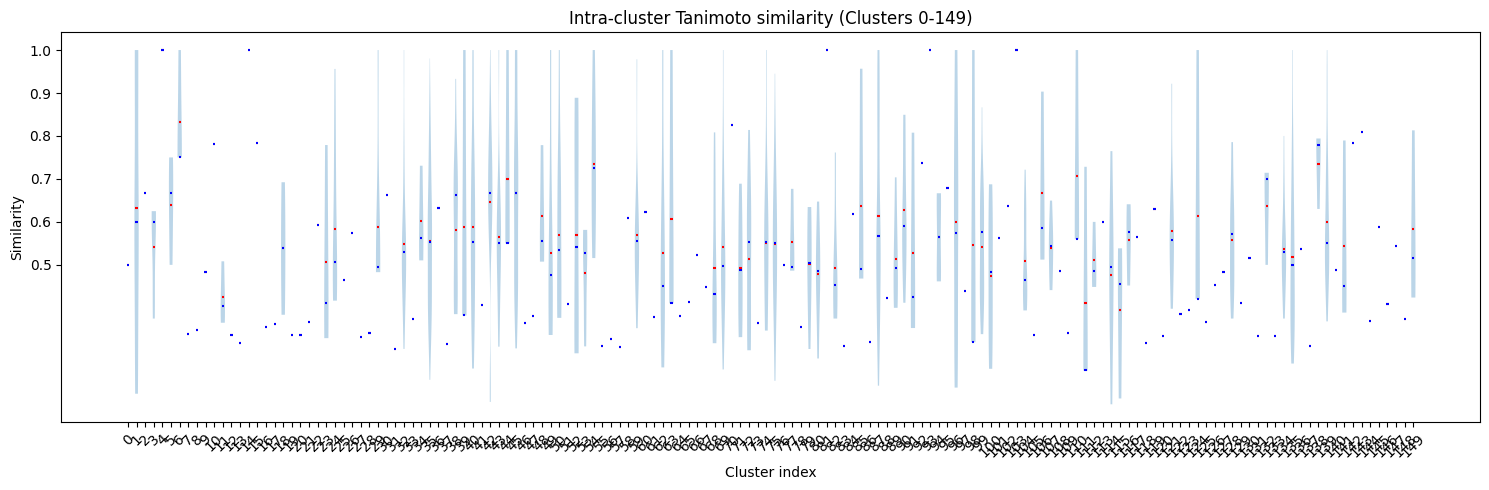

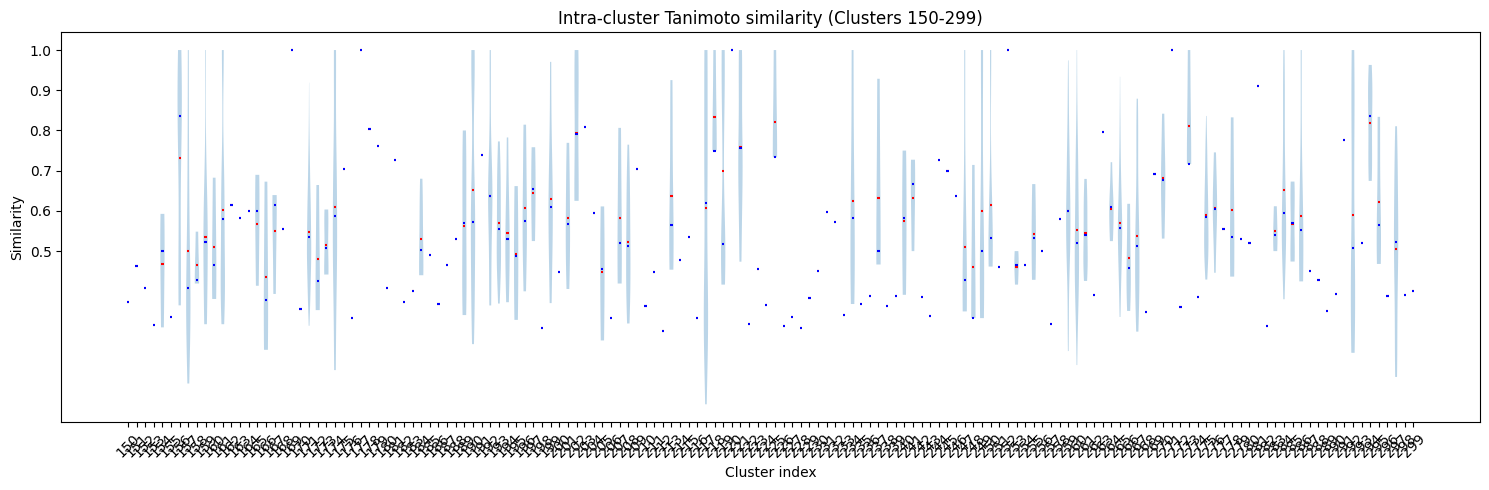

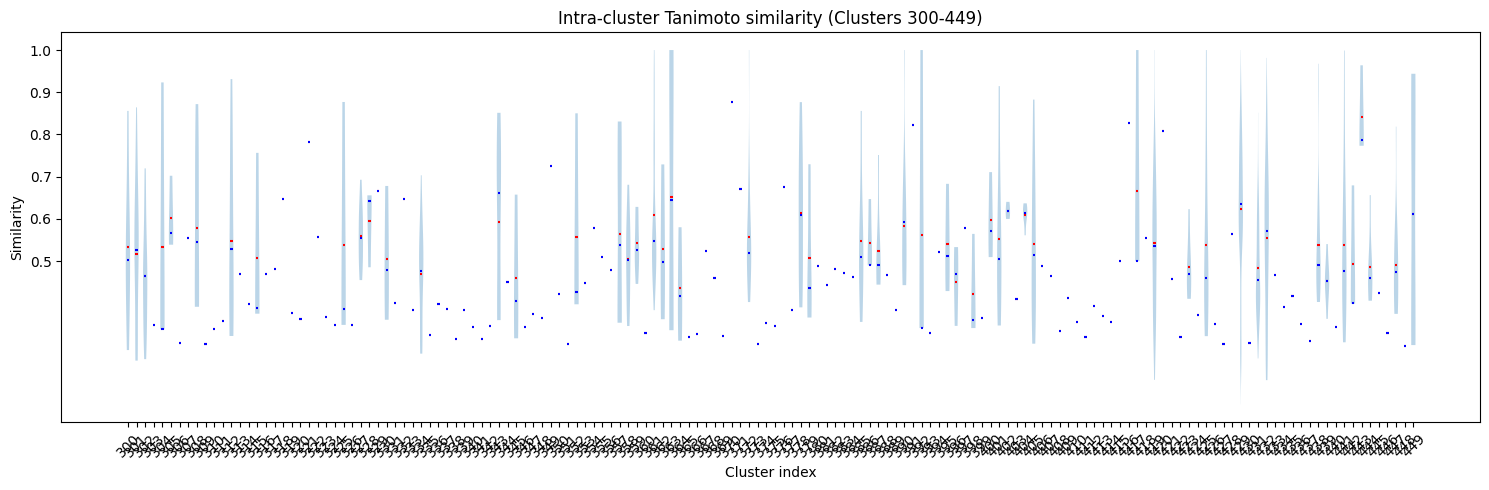

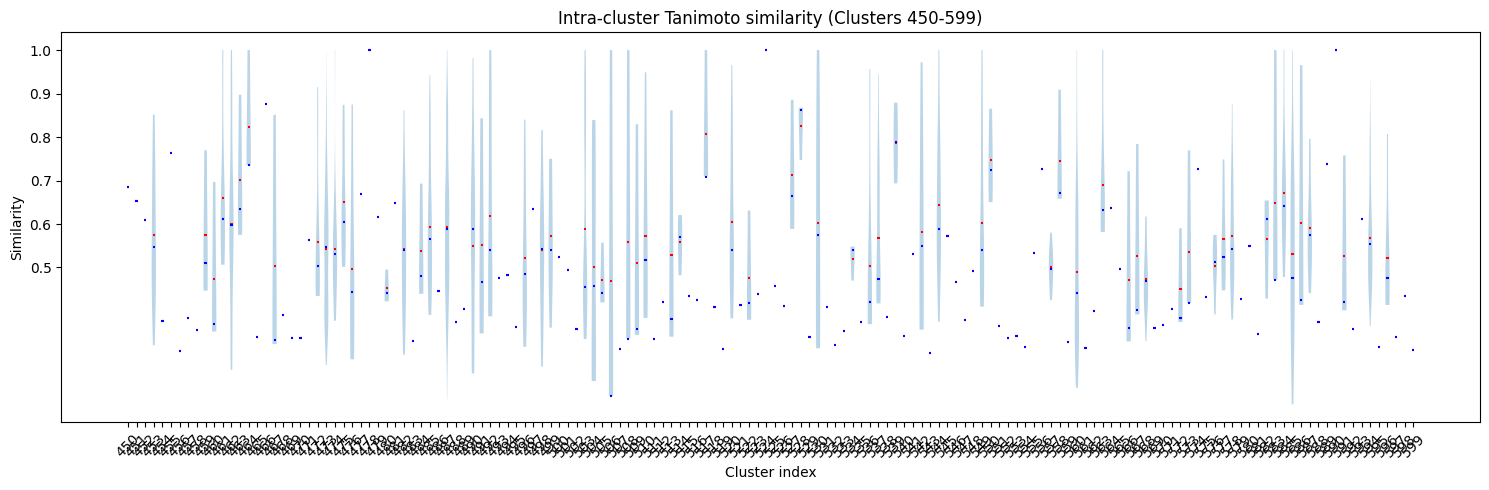

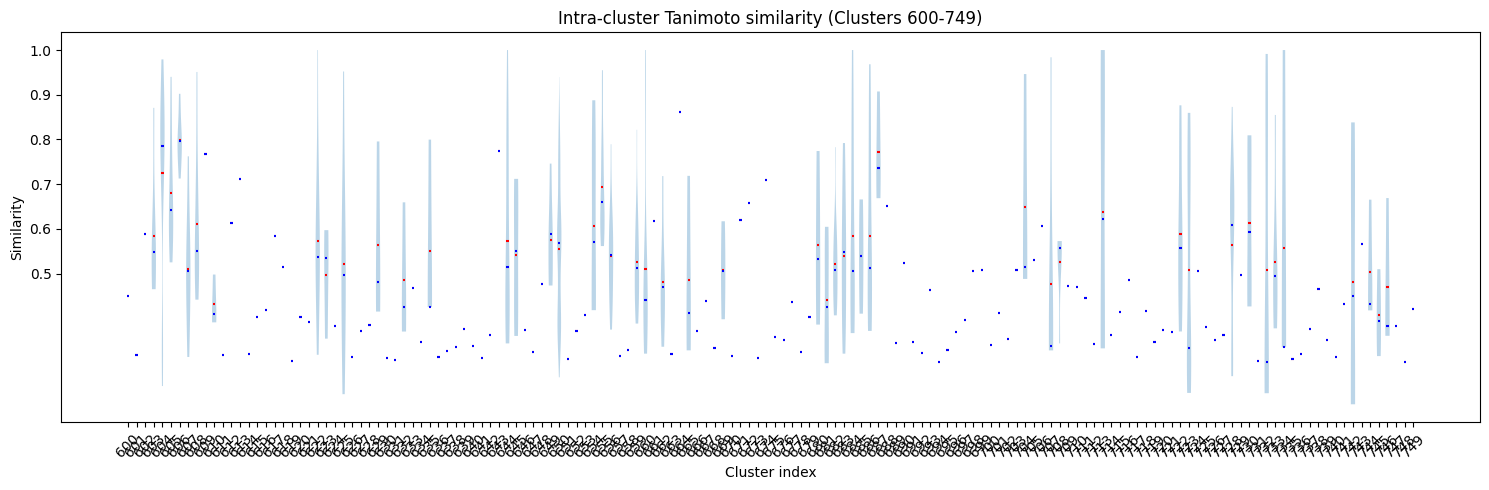

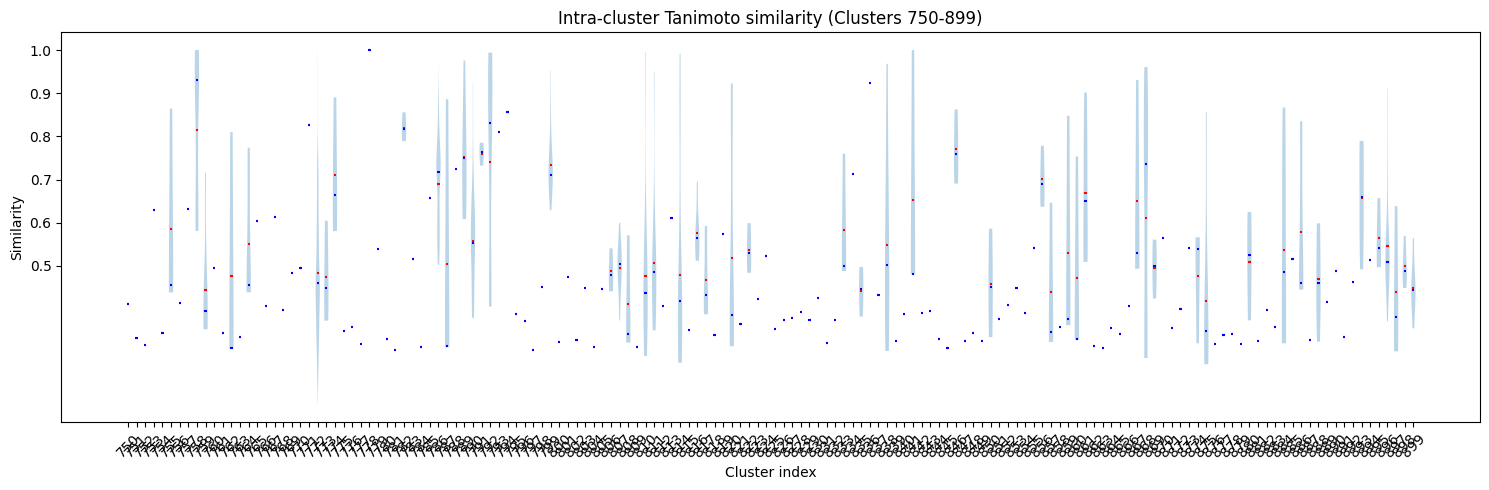

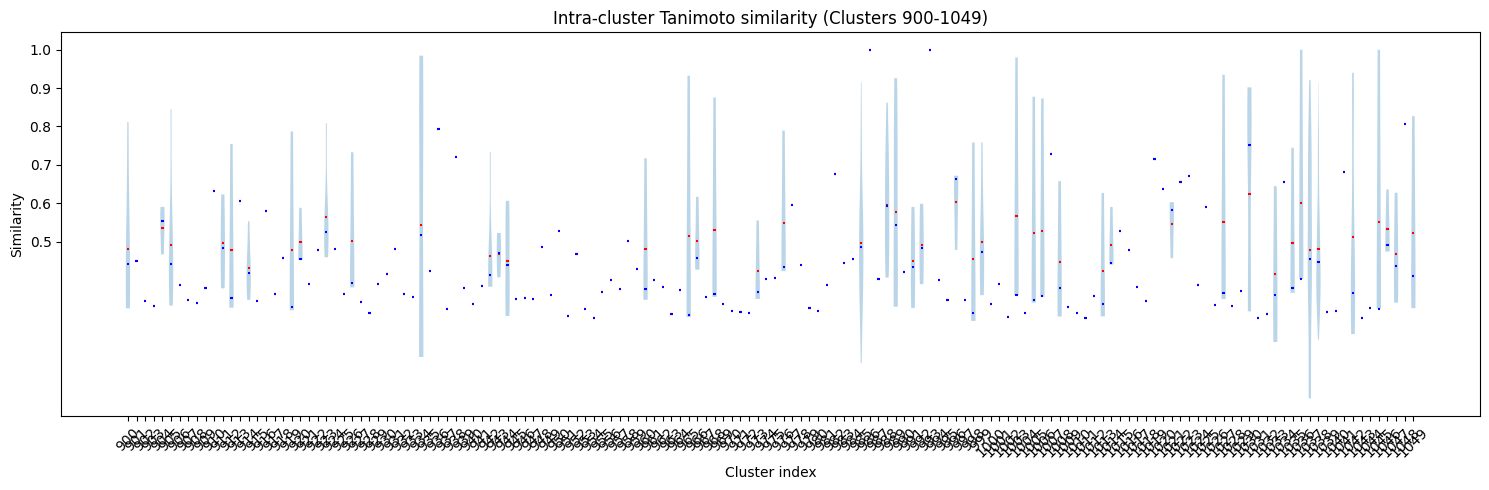

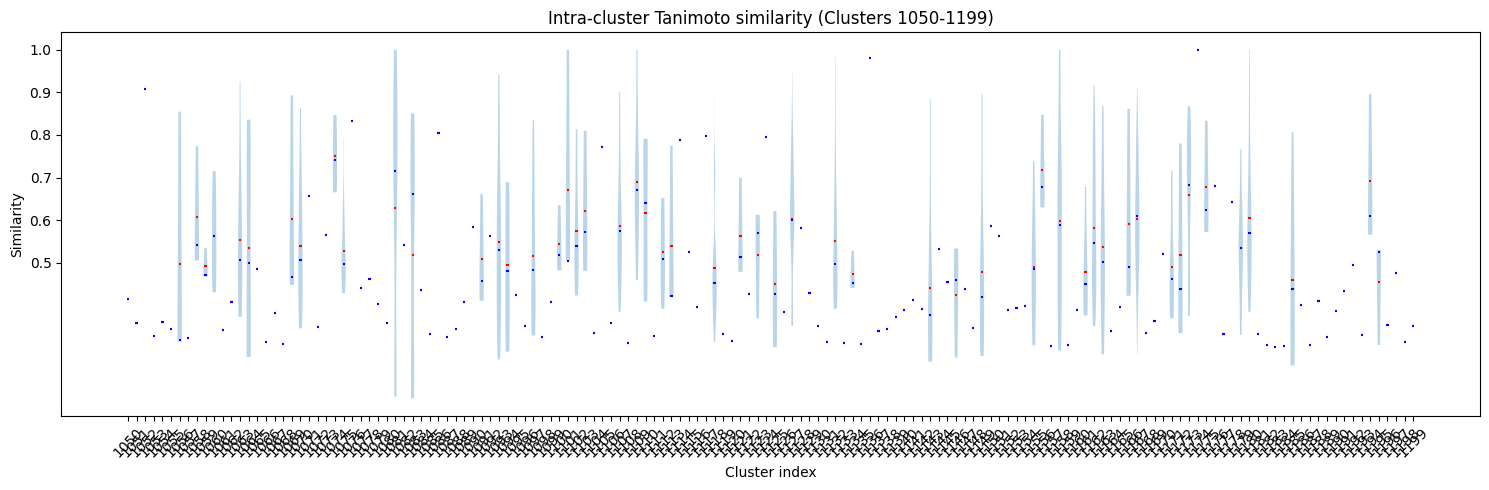

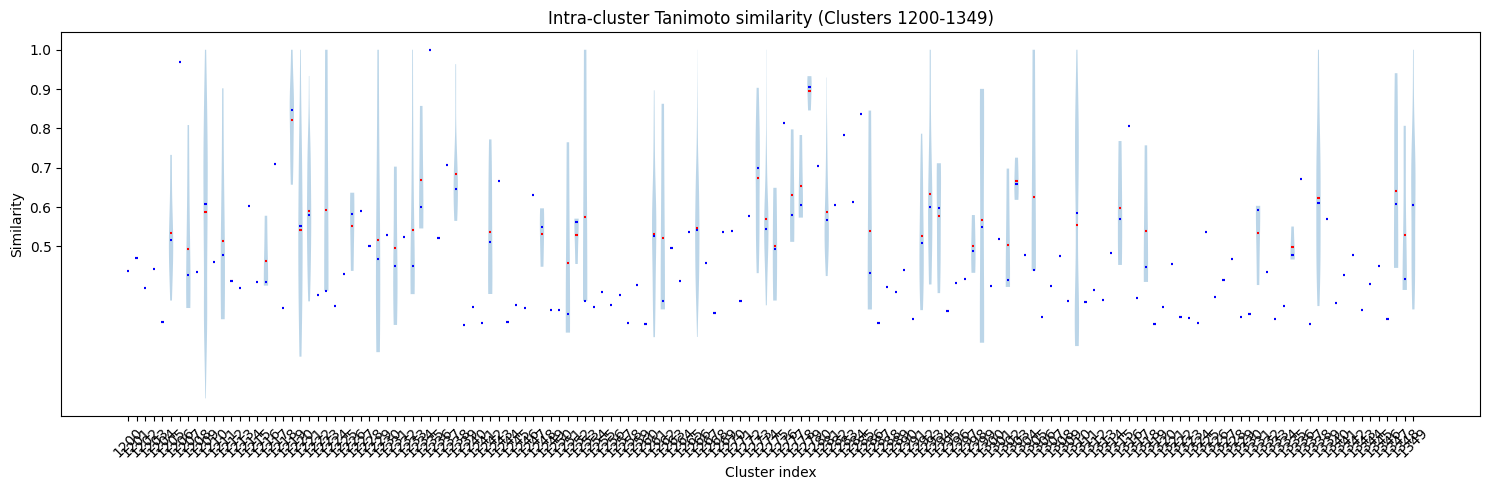

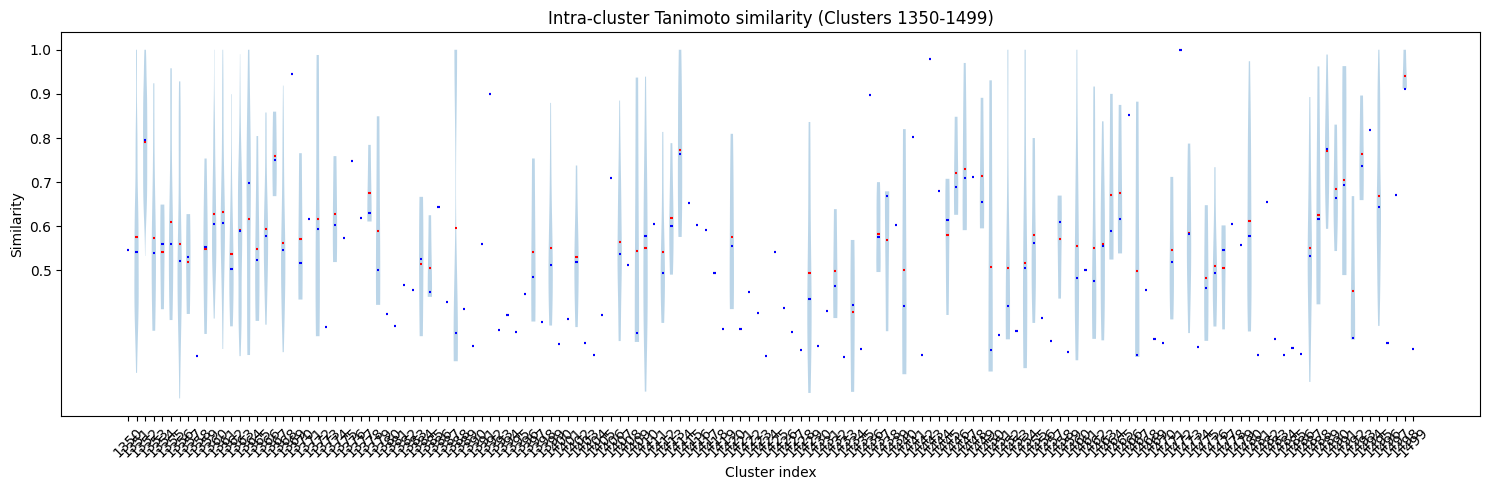

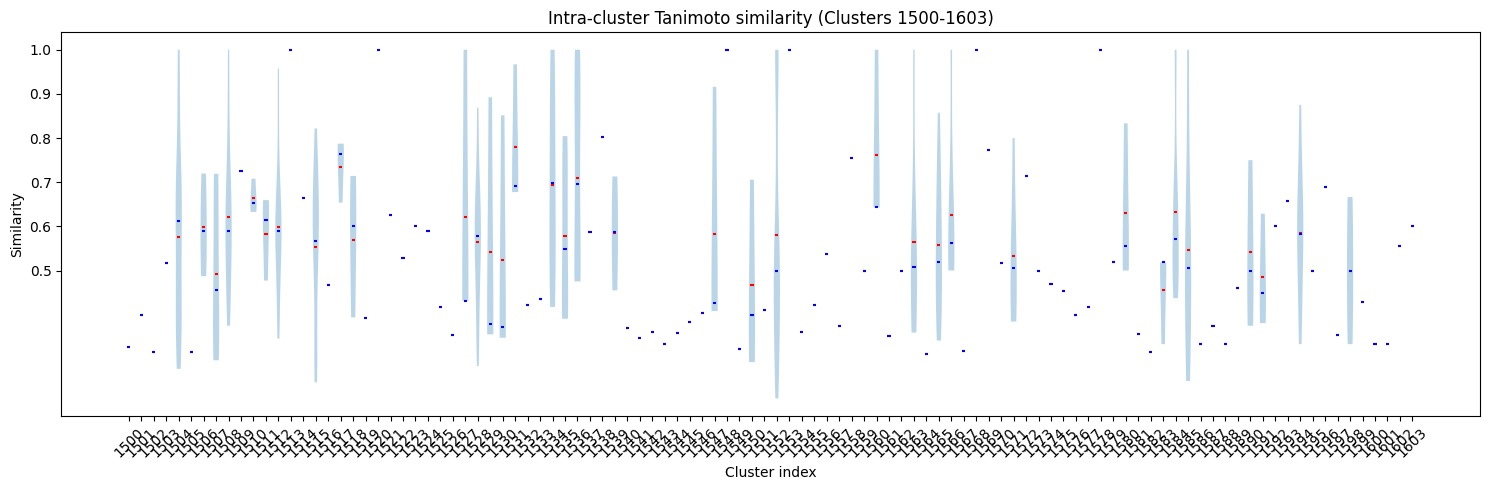

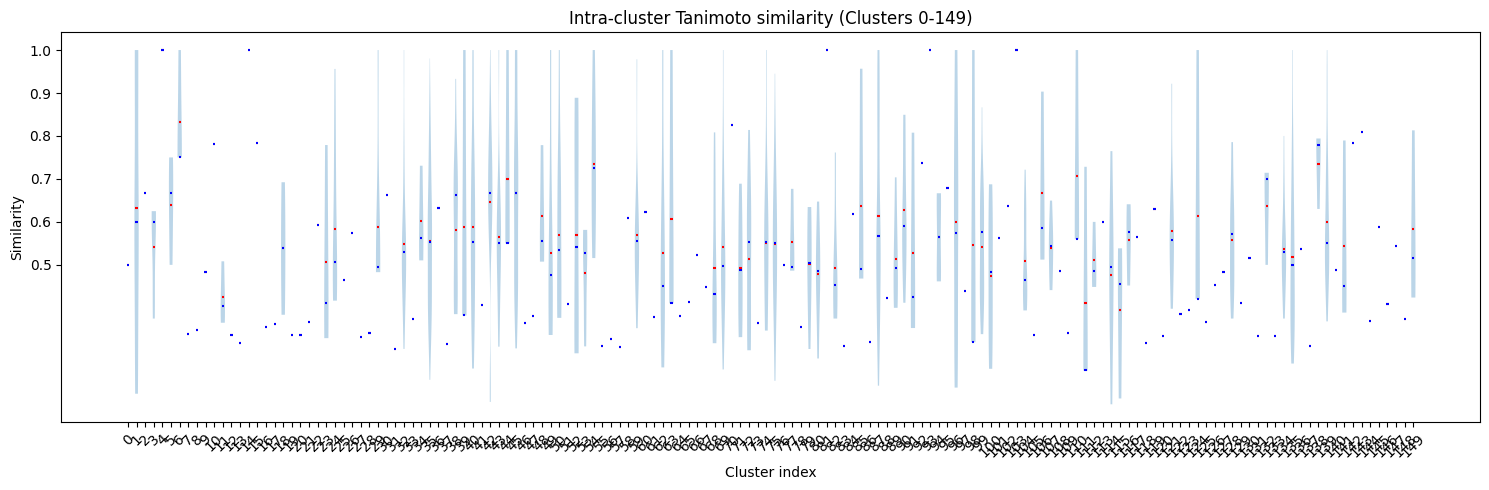

In [7]:
def remove_singletons(cluster_mol_ids):
    """Remove clusters that contain only one molecule"""
    return [cluster for cluster in cluster_mol_ids if len(cluster) > 1]

def tanimoto_distance_matrix(fingerprints):
    """Compute Tanimoto distance matrix for a list of fingerprints"""
    n = len(fingerprints)
    distances = []
    for i in range(n):
        for j in range(i+1, n):
            dist = 1 - DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            distances.append(dist)
    return distances

def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    for cluster in fps_clusters:
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

def prepare_cluster_fingerprints(cluster_mol_ids, smiles_list, start_idx, end_idx):
    """Convert molecules in clusters to fingerprints for a specific range"""
    mol_fps_per_cluster = []
    
    for cluster_idx, mol_indices in enumerate(cluster_mol_ids[start_idx:end_idx], start_idx):
        cluster_fps = []
        for idx in mol_indices:
            try:
                mol = Chem.MolFromSmiles(smiles_list[idx], sanitize=False)
                if mol is not None:
                    Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_ALL^Chem.SANITIZE_KEKULIZE)
                    fp = AllChem.RDKFingerprint(mol)
                    cluster_fps.append(fp)
            except Exception as e:
                print(f"Error processing molecule in cluster {cluster_idx}: {str(e)}")
                continue
        if len(cluster_fps) > 1:  # Only add clusters with more than one fingerprint
            mol_fps_per_cluster.append(cluster_fps)
    
    return mol_fps_per_cluster

def plot_intracluster_similarity_range(cluster_mol_ids, smiles_list, start_idx, end_idx):
    """Plot intra-cluster Tanimoto similarity violin plot for a specific range"""
    # Prepare fingerprints for the range
    mol_fps_per_cluster = prepare_cluster_fingerprints(cluster_mol_ids, smiles_list, start_idx, end_idx)
    
    if not mol_fps_per_cluster:
        print(f"No valid clusters found in range {start_idx}-{end_idx}")
        return None
    
    # Compute intra-cluster similarity
    intra_sim = intra_tanimoto(mol_fps_per_cluster)
    
    # Create violin plot
    fig, ax = plt.subplots(figsize=(15, 5))
    indices = list(range(len(intra_sim)))
    
    # Setup axis
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Similarity")
    ax.set_xticks(indices)
    ax.set_xticklabels(range(start_idx, start_idx + len(indices)))
    ax.set_yticks(np.arange(0.5, 2, 0.1))
    ax.set_title(f"Intra-cluster Tanimoto similarity (Clusters {start_idx}-{end_idx-1})", fontsize=12)
    
    # Create violin plot with means and medians
    r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
    r["cmeans"].set_color("red")
    r["cmedians"].set_color("blue")
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    return fig

def plot_all_clusters_in_batches(cluster_mol_ids, smiles_list, batch_size=150, save_plots=False):
    """Plot all clusters in batches of specified size"""
    # Remove singletons before processing
    non_singleton_clusters = remove_singletons(cluster_mol_ids)
    total_clusters = len(non_singleton_clusters)
    
    print(f"Total clusters after removing singletons: {total_clusters}")
    print(f"Removed {len(cluster_mol_ids) - total_clusters} singleton clusters")
    
    for start_idx in range(0, total_clusters, batch_size):
        end_idx = min(start_idx + batch_size, total_clusters)
        fig = plot_intracluster_similarity_range(non_singleton_clusters, smiles_list, start_idx, end_idx)
        
        if fig is not None:
            if save_plots:
                fig.savefig(f'cluster_similarity_{start_idx}-{end_idx-1}.png', 
                           dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

# Example usage:
# First remove singletons from your cluster_mol_ids
non_singleton_clusters = remove_singletons(cluster_mol_ids)

# To plot all clusters in batches
plot_all_clusters_in_batches(non_singleton_clusters, smiles_list, batch_size=150, save_plots=True)

# To plot a specific range:
fig = plot_intracluster_similarity_range(non_singleton_clusters, smiles_list, 0, 150)
plt.show()

Merge clusters based on Tanimoto similarity of MCS 


Analyzing initial clusters...


[09:53:22] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[09:53:22] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[09:53:23] Can't kek


Initial MCS Statistics:
Total clusters: 1566
MCS found: 1542
Average molecules per MCS: 3.30
Max molecules in MCS: 44
Min molecules in MCS: 2

Removing singleton clusters...
Removed 1933 singleton clusters

Merging similar clusters...


[09:55:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[09:55:03] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[09:55:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[09:55:03] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[09:55:03] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[09:55:04] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[09:55:04] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 24
[09:55:04] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[09:55:04] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 24
[09:55:04] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[09:55:04] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 18
[09:55:04] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[09:55:04] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 26 27
[09:55:04] Can't kekulize mol.  Unkekulized


Analyzing merged clusters...


[11:44:20] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[11:44:20] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
[11:44:21] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 32
[11:44:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[11:44:21] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[11:44:21] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[11:44:21] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[11:44:21] Can't kekulize mol.  Unkekulized atoms: 58 59 60 61 62 63 64 65 66
[11:44:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[11:44:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[11:44:21] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[11:44:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[11:44:21] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[11:44:22] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[11:44:22] 


Merged MCS Statistics:
Total merged clusters: 237
MCS found: 211
Average molecules per MCS: 17.85
Max molecules in MCS: 71
Min molecules in MCS: 3

Merged clusters saved to 0.65t_0.5b_AI_merged

Generating visualization...


[11:44:25] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[11:44:25] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
[11:44:26] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 32
[11:44:26] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[11:44:26] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[11:44:26] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[11:44:26] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[11:44:26] Can't kekulize mol.  Unkekulized atoms: 58 59 60 61 62 63 64 65 66
[11:44:26] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[11:44:26] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[11:44:26] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[11:44:26] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[11:44:26] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[11:44:27] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[11:44:27] 

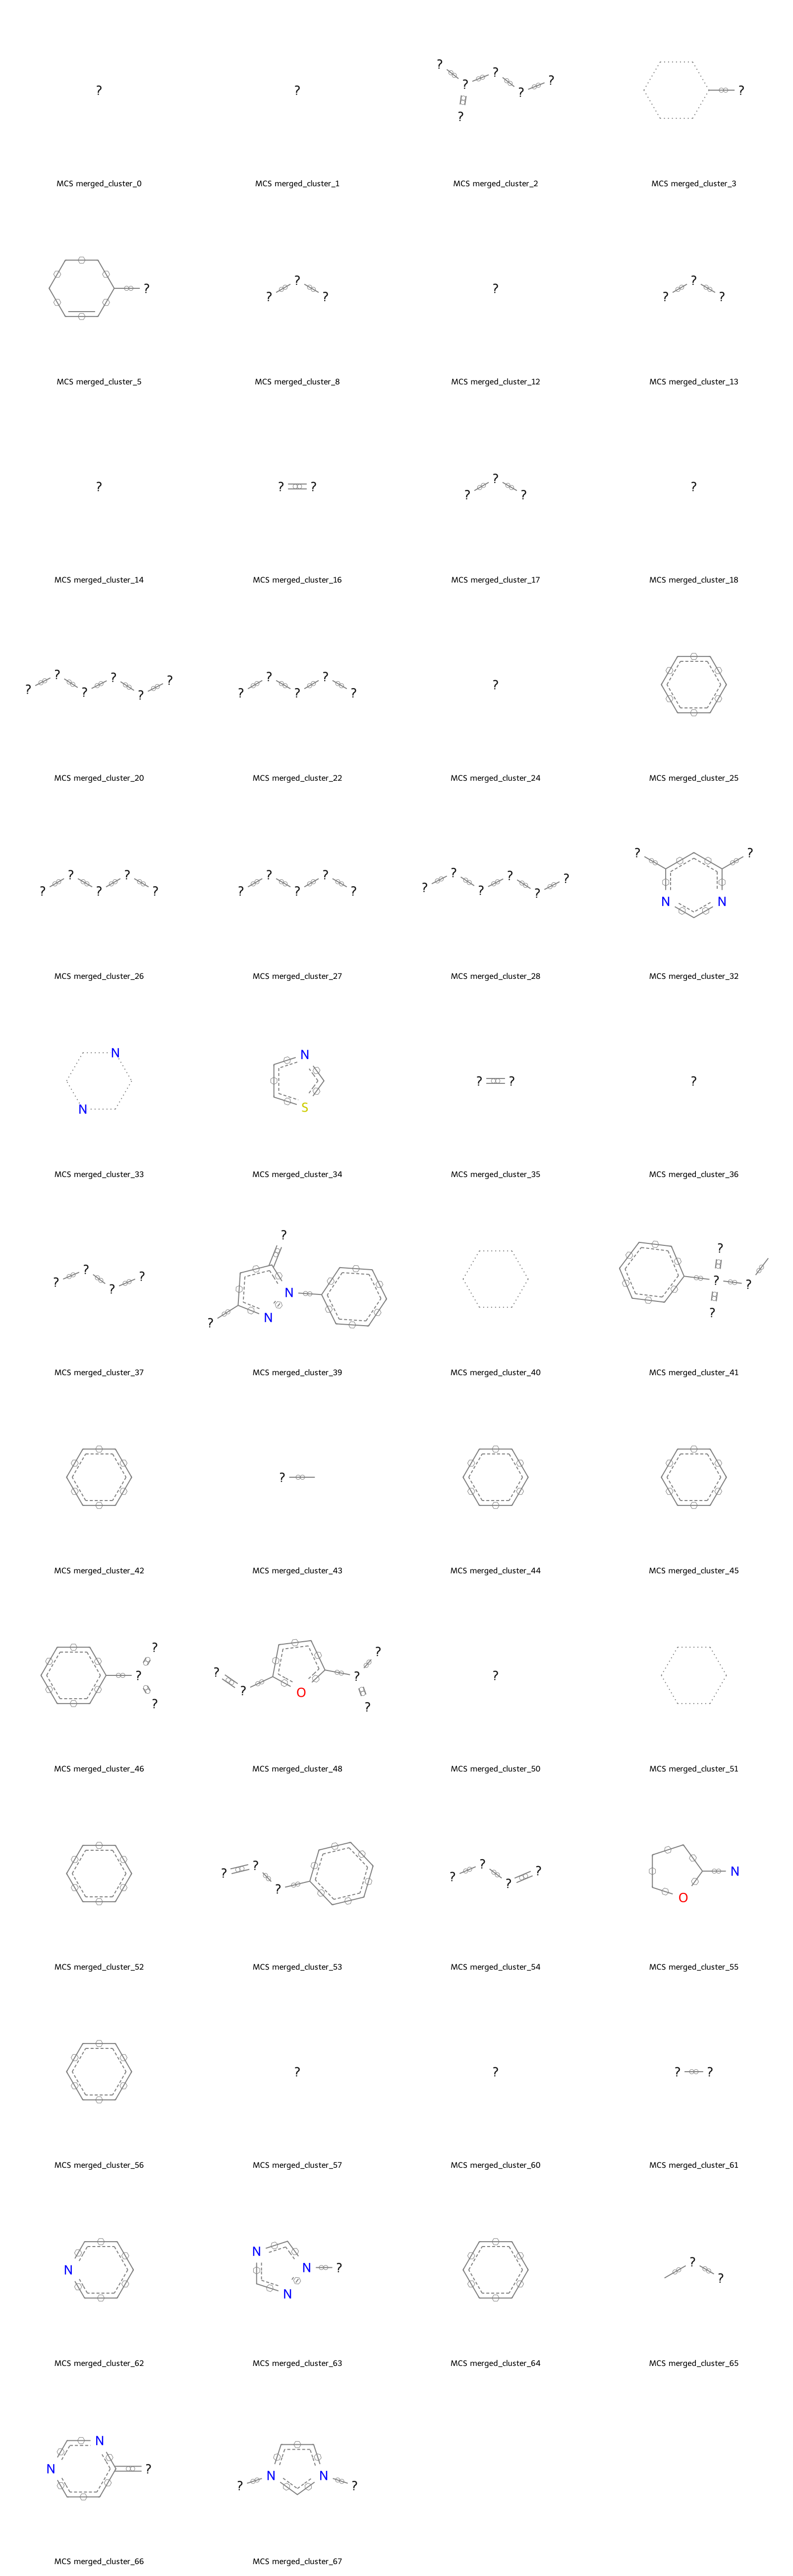

In [10]:
def count_initial_mcs(input_dir):
    """
    Analyze initial clusters and calculate MCS statistics
    """
    stats = {
        'total_clusters': 0,
        'mcs_found': 0,
        'total_molecules': 0,
        'max_molecules_in_mcs': 0,
        'min_molecules_in_mcs': float('inf'),
    }
    
    for cluster_file in os.listdir(input_dir):
        if not cluster_file.endswith('.smi'):
            continue
            
        cluster_path = os.path.join(input_dir, cluster_file)
        molecules = []
        
        try:
            with open(cluster_path, 'r') as f:
                for line in f:
                    mol = Chem.MolFromSmiles(line.strip())
                    if mol is not None:
                        molecules.append(mol)
            
            if len(molecules) >= 2:
                stats['total_clusters'] += 1
                stats['total_molecules'] += len(molecules)
                
                # Find MCS for the cluster
                mcs = rdFMCS.FindMCS(molecules,
                                   timeout=10,
                                   matchValences=True,
                                   ringMatchesRingOnly=True,
                                   completeRingsOnly=True)
                
                if mcs.smartsString:
                    stats['mcs_found'] += 1
                    stats['max_molecules_in_mcs'] = max(stats['max_molecules_in_mcs'], len(molecules))
                    stats['min_molecules_in_mcs'] = min(stats['min_molecules_in_mcs'], len(molecules))
                    
        except Exception as e:
            print(f"Error processing {cluster_file}: {str(e)}")
            continue
    
    # Calculate average molecules per MCS
    if stats['mcs_found'] > 0:
        stats['avg_molecules_per_mcs'] = stats['total_molecules'] / stats['mcs_found']
    else:
        stats['avg_molecules_per_mcs'] = 0
        
    # Handle case where no valid clusters were found
    if stats['min_molecules_in_mcs'] == float('inf'):
        stats['min_molecules_in_mcs'] = 0
        
    return stats

def remove_singletons(input_dir, output_dir):
    """
    Remove singleton clusters and save non-singleton clusters to a new directory
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    singleton_count = 0
    for cluster_file in os.listdir(input_dir):
        if not cluster_file.endswith('.smi'):
            continue
            
        input_path = os.path.join(input_dir, cluster_file)
        output_path = os.path.join(output_dir, cluster_file)
        
        try:
            with open(input_path, 'r') as f:
                smiles_list = [line.strip() for line in f if line.strip()]
                
            # Skip singleton clusters
            if len(smiles_list) < 2:
                singleton_count += 1
                continue
                
            # Write non-singleton clusters to output directory
            with open(output_path, 'w') as f:
                for smiles in smiles_list:
                    f.write(f"{smiles}\n")
                    
        except IOError as e:
            print(f"Error processing file {cluster_file}: {str(e)}")
    
    print(f"Removed {singleton_count} singleton clusters")
    return output_dir

def calculate_mcs_similarity(mol1, mol2, timeout=10):
    """
    Calculate similarity between two molecules based on their Maximum Common Substructure
    """
    try:
        mcs = rdFMCS.FindMCS([mol1, mol2],
                            timeout=timeout,
                            matchValences=True,
                            ringMatchesRingOnly=True,
                            completeRingsOnly=True)
        
        if not mcs.smartsString:
            return 0.0
            
        # Calculate similarity as ratio of MCS atoms to average molecule size
        mcs_size = len(Chem.MolFromSmarts(mcs.smartsString).GetAtoms())
        avg_size = (mol1.GetNumAtoms() + mol2.GetNumAtoms()) / 2
        
        return mcs_size / avg_size
    except Exception:
        return 0.0

def merge_similar_clusters(input_dir, similarity_threshold=0.7):
    """
    Merge clusters with highly similar MCS structure
    """
    # Dictionary to store representative molecules for each cluster
    cluster_representatives = {}
    merged_clusters = defaultdict(list)
    
    # Process each cluster file
    for cluster_file in sorted(os.listdir(input_dir)):
        if not cluster_file.endswith('.smi'):
            continue
            
        cluster_path = os.path.join(input_dir, cluster_file)
        
        # Read and convert first SMILES to molecule (as representative)
        try:
            with open(cluster_path, 'r') as f:
                first_smiles = next(f).strip()
                mol = Chem.MolFromSmiles(first_smiles)
                if mol is not None:
                    cluster_representatives[cluster_file] = mol
        except Exception as e:
            print(f"Error processing {cluster_file}: {str(e)}")
            continue
    
    # Compare all pairs of clusters
    processed_clusters = set()
    for cluster1 in cluster_representatives:
        if cluster1 in processed_clusters:
            continue
            
        current_merge_group = {cluster1}
        mol1 = cluster_representatives[cluster1]
        
        for cluster2 in cluster_representatives:
            if cluster2 in processed_clusters or cluster2 == cluster1:
                continue
                
            mol2 = cluster_representatives[cluster2]
            similarity = calculate_mcs_similarity(mol1, mol2)
            
            if similarity >= similarity_threshold:
                current_merge_group.add(cluster2)
        
        # Merge clusters in the current group
        if len(current_merge_group) > 1:
            merged_name = f"merged_cluster_{len(merged_clusters)}"
            for cluster in current_merge_group:
                with open(os.path.join(input_dir, cluster), 'r') as f:
                    merged_clusters[merged_name].extend([line.strip() for line in f])
                processed_clusters.add(cluster)
    
    return merged_clusters

def analyze_merged_mcs(merged_clusters):
    """
    Analyze merged clusters and calculate MCS statistics
    """
    stats = {
        'total_merged_clusters': len(merged_clusters),
        'mcs_found': 0,
        'total_molecules': 0,
        'max_molecules_in_mcs': 0,
        'min_molecules_in_mcs': float('inf'),
    }
    
    for cluster_name, smiles_list in merged_clusters.items():
        molecules = []
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                molecules.append(mol)
        
        if len(molecules) >= 2:
            stats['total_molecules'] += len(molecules)
            
            try:
                mcs = rdFMCS.FindMCS(molecules,
                                   timeout=10,
                                   matchValences=True,
                                   ringMatchesRingOnly=True,
                                   completeRingsOnly=True)
                
                if mcs.smartsString:
                    stats['mcs_found'] += 1
                    stats['max_molecules_in_mcs'] = max(stats['max_molecules_in_mcs'], len(molecules))
                    stats['min_molecules_in_mcs'] = min(stats['min_molecules_in_mcs'], len(molecules))
            
            except Exception as e:
                print(f"Error finding MCS for {cluster_name}: {str(e)}")
                continue
    
    # Calculate average molecules per MCS
    if stats['mcs_found'] > 0:
        stats['avg_molecules_per_mcs'] = stats['total_molecules'] / stats['mcs_found']
    else:
        stats['avg_molecules_per_mcs'] = 0
        
    # Handle case where no valid clusters were found
    if stats['min_molecules_in_mcs'] == float('inf'):
        stats['min_molecules_in_mcs'] = 0
        
    return stats

def save_merged_clusters(merged_clusters, output_dir):
    """
    Save merged clusters to output directory
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for cluster_name, smiles_list in merged_clusters.items():
        output_path = os.path.join(output_dir, f"{cluster_name}.smi")
        with open(output_path, 'w') as f:
            for smiles in smiles_list:
                f.write(f"{smiles}\n")

def visualize_merged_clusters(merged_clusters, mols_per_row=4):
    """
    Visualize MCS structures of merged clusters
    """
    mcs_molecules = []
    mcs_legends = []
    
    for cluster_name, smiles_list in merged_clusters.items():
        # Convert SMILES to molecules
        molecules = []
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                molecules.append(mol)
        
        if len(molecules) < 2:
            continue
            
        # Find MCS for the merged cluster
        try:
            mcs = rdFMCS.FindMCS(molecules,
                                timeout=10,
                                matchValences=True,
                                ringMatchesRingOnly=True,
                                completeRingsOnly=True)
            
            if mcs.smartsString:
                mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
                if mcs_mol:
                    mcs_molecules.append(mcs_mol)
                    mcs_legends.append(f"MCS {cluster_name}")
        except Exception as e:
            print(f"Error finding MCS for {cluster_name}: {str(e)}")
            continue
    
    if mcs_molecules:
        img = Draw.MolsToGridImage(
            mcs_molecules,
            molsPerRow=mols_per_row,
            subImgSize=(400, 400),
            legends=mcs_legends,
            returnPNG=False
        )
        return img
    else:
        print("No MCS structures found")
        return None

def process_clusters(input_dir='0.65t_0.5b_AI', similarity_threshold=0.8):
    """
    Process clusters and analyze MCS before and after merging
    """
    # Step 1: Analyze initial MCS
    print("\nAnalyzing initial clusters...")
    initial_mcs_stats = count_initial_mcs(input_dir)
    print("\nInitial MCS Statistics:")
    print(f"Total clusters: {initial_mcs_stats['total_clusters']}")
    print(f"MCS found: {initial_mcs_stats['mcs_found']}")
    print(f"Average molecules per MCS: {initial_mcs_stats['avg_molecules_per_mcs']:.2f}")
    print(f"Max molecules in MCS: {initial_mcs_stats['max_molecules_in_mcs']}")
    print(f"Min molecules in MCS: {initial_mcs_stats['min_molecules_in_mcs']}")
    
    # Step 2: Remove singletons
    print("\nRemoving singleton clusters...")
    non_singleton_dir = input_dir + "_no_singletons"
    remove_singletons(input_dir, non_singleton_dir)
    
    # Step 3: Merge similar clusters
    print("\nMerging similar clusters...")
    merged_clusters = merge_similar_clusters(non_singleton_dir, similarity_threshold)
    
    # Step 4: Analyze merged MCS
    print("\nAnalyzing merged clusters...")
    merged_mcs_stats = analyze_merged_mcs(merged_clusters)
    print("\nMerged MCS Statistics:")
    print(f"Total merged clusters: {merged_mcs_stats['total_merged_clusters']}")
    print(f"MCS found: {merged_mcs_stats['mcs_found']}")
    print(f"Average molecules per MCS: {merged_mcs_stats['avg_molecules_per_mcs']:.2f}")
    print(f"Max molecules in MCS: {merged_mcs_stats['max_molecules_in_mcs']}")
    print(f"Min molecules in MCS: {merged_mcs_stats['min_molecules_in_mcs']}")
    
    # Step 5: Save merged clusters
    merged_dir = input_dir + "_merged"
    save_merged_clusters(merged_clusters, merged_dir)
    print(f"\nMerged clusters saved to {merged_dir}")
    
    # Step 6: Visualize merged clusters
    print("\nGenerating visualization...")
    img = visualize_merged_clusters(merged_clusters)
    if img:
        from IPython.display import display
        display(img)
    
    return merged_clusters, initial_mcs_stats, merged_mcs_stats

if __name__ == "__main__":
    # Example usage
    merged_clusters, initial_stats, merged_stats = process_clusters(
        input_dir='0.65t_0.5b_AI',
        similarity_threshold=0.65
    )

Visual of merged clusters

[11:48:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[11:48:57] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[11:48:57] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[11:48:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[11:48:57] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[11:48:57] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[11:48:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7
[11:48:57] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[11:48:59] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8 9 10 11
[11:48:59] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[11:48:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[11:48:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[11:49:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[11:49:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
[11:49:01] Can't ke

Cluster Molecule Counts:
merged_cluster_0.smi: 9 valid molecules
merged_cluster_1.smi: 11 valid molecules
merged_cluster_10.smi: 53 valid molecules
merged_cluster_100.smi: 31 valid molecules
merged_cluster_101.smi: 4 valid molecules
merged_cluster_102.smi: 26 valid molecules
merged_cluster_103.smi: 12 valid molecules
merged_cluster_104.smi: 11 valid molecules
  Invalid SMILES in merged_cluster_104.smi: 5
merged_cluster_105.smi: 14 valid molecules
merged_cluster_106.smi: 6 valid molecules
merged_cluster_107.smi: 4 valid molecules
merged_cluster_108.smi: 5 valid molecules
merged_cluster_109.smi: 6 valid molecules
merged_cluster_11.smi: 9 valid molecules
merged_cluster_110.smi: 35 valid molecules
merged_cluster_111.smi: 41 valid molecules
merged_cluster_112.smi: 8 valid molecules
merged_cluster_113.smi: 6 valid molecules
merged_cluster_114.smi: 4 valid molecules
merged_cluster_115.smi: 30 valid molecules
merged_cluster_116.smi: 26 valid molecules
merged_cluster_117.smi: 9 valid molecules


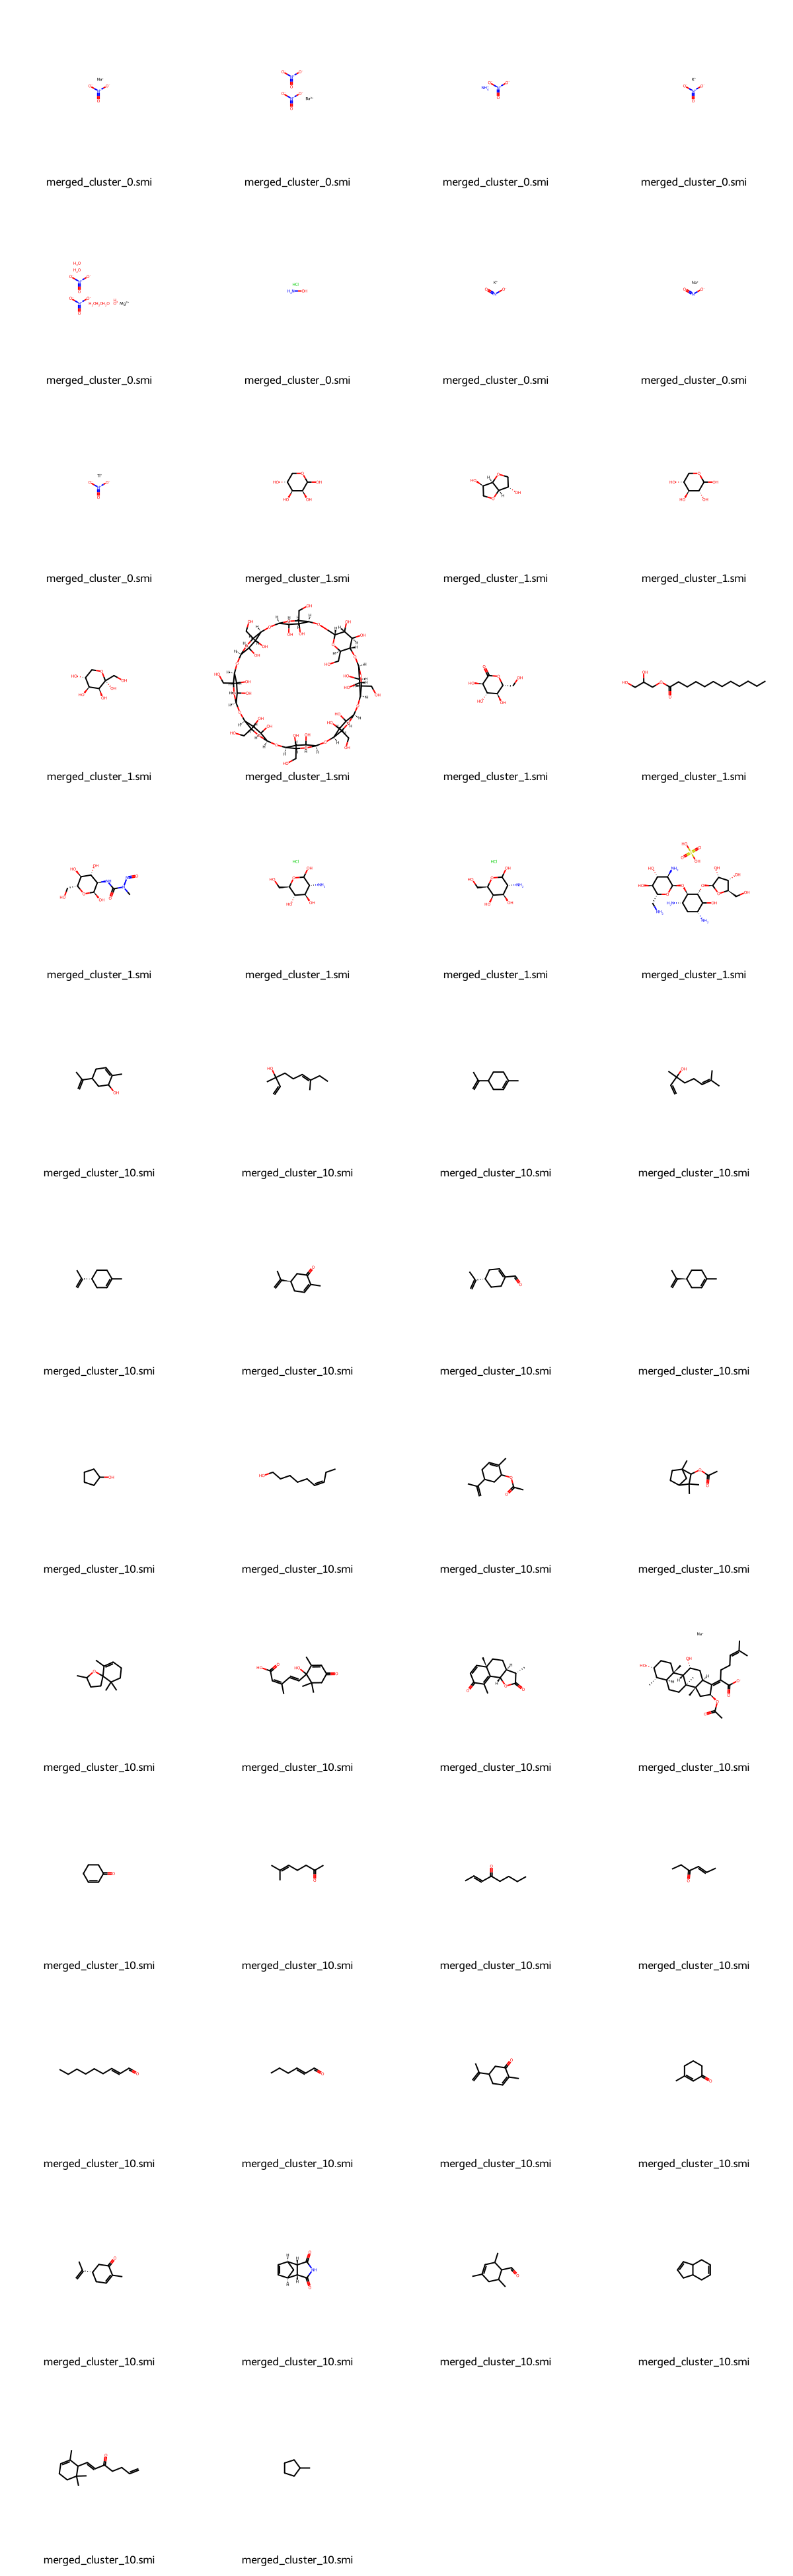

In [11]:
def debug_molecule_visualization(input_dir='0.65t_0.5b_AI_merged'):
    
    cluster_molecules = {}
    invalid_smiles = {}
    
    for cluster_file in sorted(os.listdir(input_dir)):
        if not cluster_file.endswith('.smi'):
            continue
        
        cluster_path = os.path.join(input_dir, cluster_file)
        
        try:
            with open(cluster_path, 'r') as f:
                smiles_list = [line.strip() for line in f if line.strip()]
        except IOError:
            print(f"Error reading file: {cluster_path}")
            continue
        
        cluster_molecules[cluster_file] = []
        invalid_smiles[cluster_file] = []
        
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                cluster_molecules[cluster_file].append(mol)
            else:
                invalid_smiles[cluster_file].append(smiles)
    
    # Collect all valid molecules with cluster labels
    all_molecules = []
    all_legends = []
    
    for cluster, molecules in cluster_molecules.items():
        for mol in molecules:
            all_molecules.append(mol)
            all_legends.append(f"{cluster}")
    
    print("Cluster Molecule Counts:")
    for cluster, molecules in cluster_molecules.items():
        print(f"{cluster}: {len(molecules)} valid molecules")
        if invalid_smiles[cluster]:
            print(f"  Invalid SMILES in {cluster}: {len(invalid_smiles[cluster])}")
    
    if all_molecules:
        return Draw.MolsToGridImage(
            all_molecules, 
            molsPerRow=4, 
            subImgSize=(300, 300),
            legends=all_legends
        )
    else:
        print("No valid molecules found")
        return None

debug_molecule_visualization()